In [1]:
from fastai2.vision.all import *
from faststyle import *
from nbdev.showdoc import *

In [2]:
source = untar_data(URLs.COCO_SAMPLE)

In [3]:
fns = get_image_files(source)

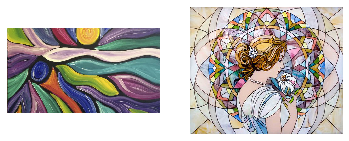

In [4]:
style_dir = Path('styles')
style_fns = L('abstract.jpg', 'mosaic.jpg')
style_fns = style_fns.map(lambda o: style_dir/o)
show_images([PILImage.create(fn) for fn in style_fns])

In [5]:
def get_items(path, n=2):
  fns = get_image_files(source)
  return fns.map(lambda o: [o, random_weights(n)])

In [6]:
fns_pairs = get_items(source)
dset = Datasets(fns_pairs, splits=RandomSplitter()(fns),
                tfms=[[lambda o: ImageWeight.create(*o)], [itemgetter(0), PILImage.create]])

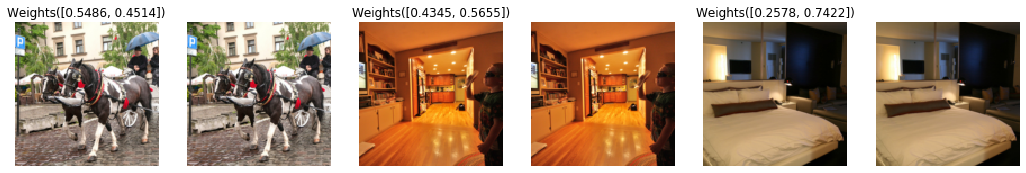

In [7]:
dls = dset.dataloaders(bs=42,
                       after_item=[ToTensor(), Resize(128), RandomizeWeights],
                       after_batch=[IntToFloatTensor, NormalizeX.from_stats(*coco_stats)])
dls.show_batch(max_n=3)

In [8]:
layer_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [9]:
loss_func = FastStyleLoss(stl_w=3e5, tv_w=300)
cbs = [FeatsCallback.from_fns(style_fns, layer_feats), WeightsCallback()]
learn = Learner(dls, TransformerNet2(2), loss_func, cbs=cbs, metrics=loss_func.metrics)

In [18]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,stl,cnt,tv,time
0,47.684025,49.795525,21.955088,21.624914,6.215522,04:23
1,46.393894,46.050873,19.013718,21.092611,5.944545,04:18
2,44.518238,44.693226,17.967127,20.807301,5.918786,04:18
3,43.009480,43.591145,17.310341,20.428381,5.852427,04:19
4,42.888470,43.199291,17.051052,20.292906,5.855334,04:19


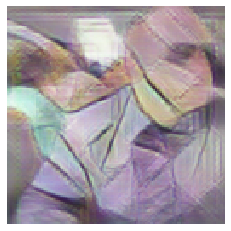

In [19]:
pred,_,_=learn.predict([fns[0], [.99, .01]])
pred.show()

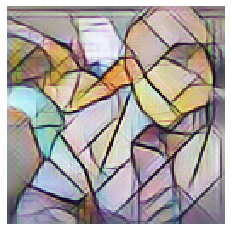

In [20]:
pred,_,_=learn.predict([fns[0], [.01, .99]])
pred.show()

In [29]:
b = [
  [[fns[0], [0.2, 0.8]]]
]

In [48]:
items = [[fns[0], [0.2, 0.8]]]
dl = dls.test_dl(fns_pairs[:30], with_label=True)

In [49]:
learn.show_results(dl=dl)

AssertionError: Match length mismatch